#### <b>Download the Dataset</b>

* The dataset contains approximately 13,000 Korean "human face" images.
* In this dataset, all faces are cropped to a resolution of 128 X 128 pixels, although some of the original images have been high resolution.
* Each image filename indicates which family (household) number it belongs to.

In [3]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

zsh:1: no matches found: https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1
unzip:  cannot find or open custom_korean_family_dataset_resolution_128.zip, custom_korean_family_dataset_resolution_128.zip.zip or custom_korean_family_dataset_resolution_128.zip.ZIP.


#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [33]:
# ! pip install pillow
# ! pip install matplotlib
# ! pip install pandas
# ! pip install torch torchvision torchaudio
# ! pip install scikit-learn
# ! pip install tqdm

In [34]:
DEVICE = 'mps'

In [2]:
import os
import time
import random
import glob
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection

In [3]:
def set_random_seed(seed=0):
    torch.manual_seed(seed + 0)
    torch.cuda.manual_seed(seed + 1)
    torch.cuda.manual_seed_all(seed + 2)
    np.random.seed(seed + 3)
    torch.cuda.manual_seed_all(seed + 4)
    random.seed(seed + 5)

#### <b>Family Relationship Dataset</b>

1. It consists of a total of 900 households and approximately exact 13,068 individuals.
2. The last part of the filename, such as "a1", indicates the "age group".
  * This dataset consists of 8 age group classes.
  * The task is one of the 8-classes classification problem.
  * If we perform random guessing, the accuracy is approximately 12.5%.
3. The age classification problem is somewhat challenging, thus, we expect that our dataset will be helpful for evaluating the forgetting performance of a machine unlearning algorithm.
  * Our proposed setting has been configured in a way that is almost similar to the NeurIPS Kaggle Competition 2023 held on Kaggle.
4. We have utilized "Family Relationship Dataset" from AI Hub for constructing this dataset.
  * <b>Link</b>: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=528

#### <b>Load Datasets 1</b>

* The following three datasets do not overlap at the household level.
  * Thus, our setting ensures any individual "subjects" are overlapped across the following three sub-dataset.
  * In other wrods, we set any person (subject) to do not simultaneously belonging to the $\mathcal{D}_{train}$, $\mathcal{D}_{test}$ and $\mathcal{D}_{unseen}$.
* <b>Training dataset $\mathcal{D}_{train}$</b>: (F0001 ~ F0299) folders have 10,025 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: (F0801 ~ F0850) folders have 1,539 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: (F0851 ~ F0900) folders have 1,504 images.

In [4]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [5]:
class CustomDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
PATH_TO_CHECKPOINTS = Path('./checkpoints')
PATH_TO_CHECKPOINTS.mkdir(exist_ok=True, parents=True)

In [11]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/new_custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

shadow_meta_data_dir = Path("./custom_korean_family_dataset_resolution_128/custom_shadow_dataset")

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

test_dataset = CustomDataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

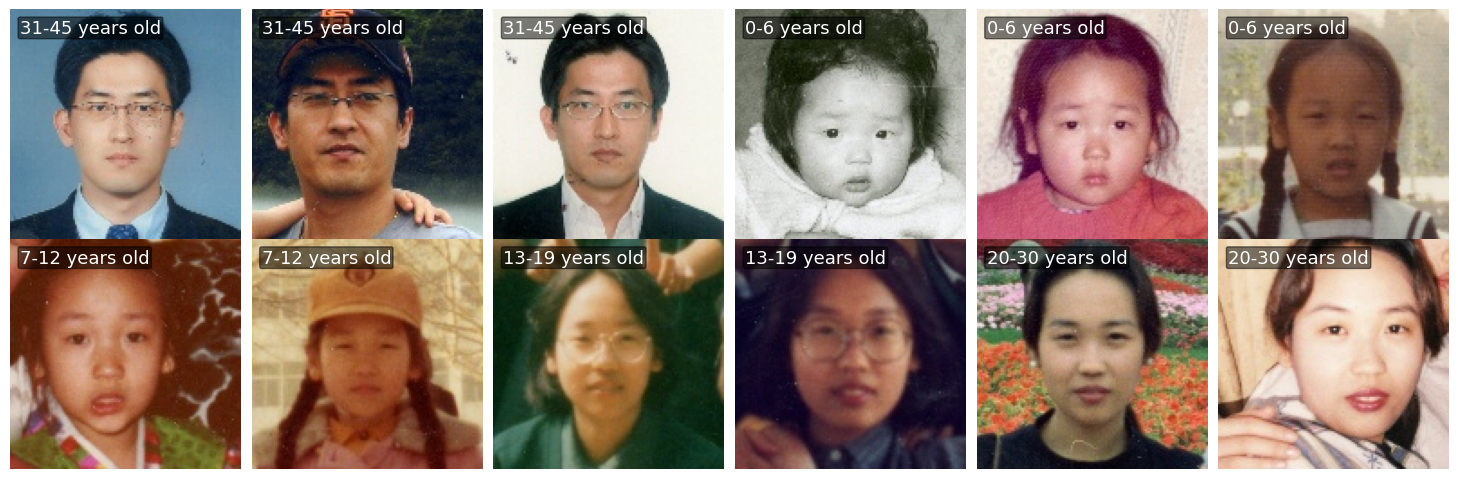

In [12]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

#### <b>Train the "Original Model"</b>

* Train the Original model to serve as the base model for performing Machine Unlearning

In [35]:
learning_rate = 0.01
log_step = 30

model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [36]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [37]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_original_epochs = 30
best_test_acc = 0
best_epoch = 0

In [38]:
set_random_seed(42)

path_to_origin_checkpoint = PATH_TO_CHECKPOINTS/'origin'
path_to_origin_checkpoint.mkdir(parents=True, exist_ok=True)

history = []
accuracy = []
for epoch in range(num_original_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    test_loss, test_acc = test()
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

torch.save(model.state_dict(), path_to_origin_checkpoint/'resnet18.pth')

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.033153096896906695, running train accuracy: 0.16562500596046448
[Batch: 60] running train loss: 0.03301508727793892, running train accuracy: 0.17994791269302368
train loss: 0.03330652949632473, accuracy: 0.18321600556373596
elapsed time: 13.944822072982788
[Test]
[Batch: 1] running test loss: 0.04301337152719498, running test accuracy: 0.234375
test loss: 0.03928330248249592, accuracy: 0.1513970047235489
elapsed time: 1.4279632568359375
[Epoch: 2 - Training]
[Batch: 30] running train loss: 0.031238973575333753, running train accuracy: 0.23906250298023224
[Batch: 60] running train loss: 0.031325334465752044, running train accuracy: 0.25
train loss: 0.0312205621294288, accuracy: 0.25546500086784363
elapsed time: 12.062114000320435
[Test]
[Batch: 1] running test loss: 0.03462165594100952, running test accuracy: 0.265625
test loss: 0.034890828773989316, accuracy: 0.2163742631673813
elapsed time: 1.1438961029052734
[Epoch: 3 - Training

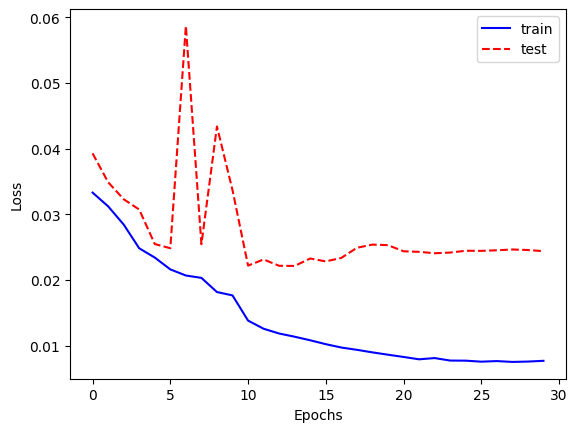

In [39]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

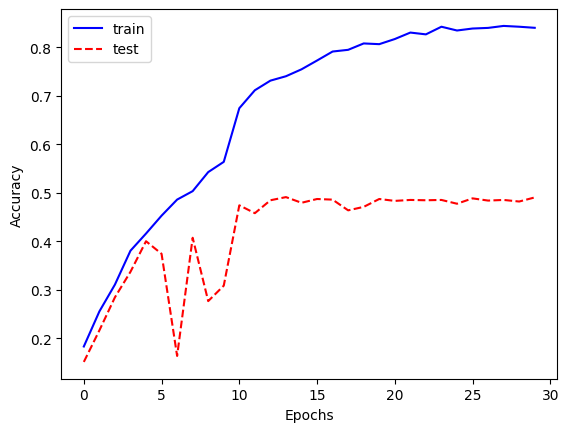

In [40]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='test')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#### <b> Train the "Shadow Models"</b>
* The models which will be used for MIA

In [13]:
def train_shadow(model):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(shadow_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [14]:
path_to_shadow_checkpoint = PATH_TO_CHECKPOINTS/'shadow'
path_to_shadow_checkpoint.mkdir(parents=True, exist_ok=True)

shadow_inds = sorted([int(x.split('.')[0]) for x in os.listdir(shadow_meta_data_dir)])

for shadow_idx in shadow_inds:

    set_random_seed(shadow_idx)

    shadow_meta_data = pd.read_csv(shadow_meta_data_dir/f'{shadow_idx:04}.csv')
    shadow_dataset = Dataset(shadow_meta_data, train_image_directory, train_transform)
    shadow_dataloader = DataLoader(shadow_dataset, batch_size=64, shuffle=True)
    
    for epoch in range(num_original_epochs):
        adjust_learning_rate(optimizer, epoch)
        train_loss, train_acc = train()
        test_loss, test_acc = test()

    torch.save(model.state_dict(), path_to_shadow_checkpoint/f'resnet18_{shadow_idx:04}.pth')

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.033498781733214855, running train accuracy: 0.15312500298023224
[Batch: 60] running train loss: 0.033075680925200385, running train accuracy: 0.1705729216337204
train loss: 0.03291480390616548, accuracy: 0.18432752788066864
elapsed time: 3.230687379837036
[Test]
[Batch: 1] running test loss: 0.03312400355935097, running test accuracy: 0.203125
test loss: 0.034447440239730946, accuracy: 0.14554905891418457
elapsed time: 0.7250175476074219


NameError: name 'history' is not defined

In [52]:
import sys
sys.path.append('..')
from MIA.utils import load_model, load_shadow_models
from MIA.score import get_logits, lira_offline


def lira(target_net):

    num_aug = 1
    fix_variance = False

    transform = train_transform if num_aug > 1 else test_transform
    forget_dataset = CustomDataset(train_meta_data, train_image_directory, transform, forget=True)
    retain_dataset = CustomDataset(train_meta_data, train_image_directory, transform, retain=True)
    dataset = ConcatDataset([forget_dataset, retain_dataset])
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    shadow_nets = load_shadow_models()

    shadow_logits = []
    target_logits = []
    dataset_labels = []

    for _ in range(num_aug):
        shadow_aug_logits = [[] for _ in range(len(shadow_nets))]
        target_aug_logits = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs, targets = inputs.cuda(), targets.cuda()

                # 1. Store shadow logits
                for i, net in enumerate(shadow_nets):
                    logits = net(inputs).cpu().tolist()
                    shadow_aug_logits[i].append(logits)
                # 2. Store target logits
                logits = target_net(inputs).cpu().tolist()
                target_aug_logits.append(logits)
            
                dataset_labels.append(targets.cpu().tolist())

        shadow_aug_logits = np.stack([np.concatenate(logits) for logits in shadow_aug_logits])  # [n_shadow, n_examples, n_classes]
        target_aug_logits = np.concatenate(target_aug_logits)  # [n_examples, n_classes]
        dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

        # Extract numerically stable logits
        shadow_aug_logits = get_logits(shadow_aug_logits, np.repeat(dataset_labels[None], len(shadow_nets), 0))
        target_aug_logits = get_logits(target_aug_logits, dataset_labels)

        shadow_logits.append(shadow_aug_logits)
        target_logits.append(target_aug_logits)

        shadow_logits = np.stack(shadow_logits, axis=-1)
        shadow_logits = np.swapaxes(shadow_logits, 0, 1)  # [n_examples, n_shadow, n_aug]
        target_logits = np.stack(target_logits, axis=-1)  # [n_examples, n_aug]
        labels = np.array([0] * len(forget_dataset) + [1] * len(retain_dataset)) # [n_examples]

        fnr, tnr, low = lira_offline(target_logits, shadow_logits, labels, fix_variance=fix_variance)

    return fnr, tnr, low

#### <b> Train the "Retrained Model"</b>
* A model trained on only the retain dataset from scratch, excluding the forget dataset.
* This model can serve as a proxy ground-truth for calculating the potential ground-truth (1) model utility and (2) forgetting score.

#### <b>Load Datasets 2</b>

* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.
* We divide training dataset $\mathcal{D}_{train}$ into a retain dataset $\mathcal{D}_{retain}$ and a forget dataset $\mathcal{D}_{forget}$.

In [42]:
unseen_dataset_train = CustomDataset(unseen_meta_data, unseen_image_directory, train_transform, forget=True)
unseen_dataloader_train = DataLoader(unseen_dataset_train, batch_size=64, shuffle=True, num_workers=4)

unseen_dataset_test = CustomDataset(unseen_meta_data, unseen_image_directory, test_transform, forget=True)
unseen_dataloader_test = DataLoader(unseen_dataset_test, batch_size=64, shuffle=False, num_workers=4)

forget_dataset_train = CustomDataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=64, shuffle=True, num_workers=4)

retain_dataset_train = CustomDataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=64, shuffle=True, num_workers=4)

forget_dataset_test = CustomDataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False, num_workers=4)

retain_dataset_test = CustomDataset(train_meta_data, train_image_directory, test_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=64, shuffle=False, num_workers=4)

In [43]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('Retain dataset size:', len(retain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset))

Train dataset size: 5398
Test dataset size: 1539
Forget dataset size: 1500
Retain dataset size: 3898


NameError: name 'unseen_dataset' is not defined

In [44]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

NameError: name 'unseen_dataset' is not defined

In [45]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [46]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [47]:
def train_model_using_only_retrain(model):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(retain_dataloader_train):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test_model(model):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [48]:
set_seed(42)

num_epochs = 30
best_test_acc = 0
best_epoch = 0
learning_rate = 0.01

retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_features, 8)
retrained_model = retrained_model.cuda()
criterion = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retrained_model.parameters(), lr=learning_rate, momentum=0.9)

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train_model_using_only_retrain(retrained_model)
    test_loss, test_acc = test_model(retrained_model)
    history.append((train_loss, test_loss))
    accuracy.append((train_acc, test_acc))

    if test_acc > best_test_acc:
        print("[Info] best test accuracy!")
        best_test_acc = test_acc
        best_epoch = epoch

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.034914475741485755, running train accuracy: 0.15260417759418488
[Batch: 60] running train loss: 0.03358893813565374, running train accuracy: 0.17630209028720856
train loss: 0.033576339315059184, accuracy: 0.17829656600952148
elapsed time: 4.871244192123413
[Test]
[Batch: 1] running test loss: 0.027430325746536255, running test accuracy: 0.3125
test loss: 0.031021496938218384, accuracy: 0.23911631107330322
elapsed time: 0.7071573734283447
[Info] best test accuracy!
[Epoch: 2 - Training]
[Batch: 30] running train loss: 0.030760530258218448, running train accuracy: 0.24895834922790527
[Batch: 60] running train loss: 0.03046364520365993, running train accuracy: 0.26354166865348816
train loss: 0.030456015793343824, accuracy: 0.26552078127861023
elapsed time: 3.1299221515655518
[Test]
[Batch: 1] running test loss: 0.029517555609345436, running test accuracy: 0.296875
test loss: 0.02940338846148416, accuracy: 0.2599090337753296
elapsed t

[Test]
[Batch: 1] running test loss: 0.027472127228975296, running test accuracy: 0.453125, running top-2 accuracy: 0.75
test loss: 0.02603116184182567, accuracy: 0.44509421702404156, top-2 accuracy: 0.7166991552956465
elapsed time: 0.777085542678833


100%|██████████| 85/85 [01:54<00:00,  1.35s/it]


Test Acc: {'Loss': 0.02603116184182567, 'Acc': 0.44509421702404156, 'Top-2 Acc': 0.7166991552956465}


Text(0, 0.5, 'TNR')

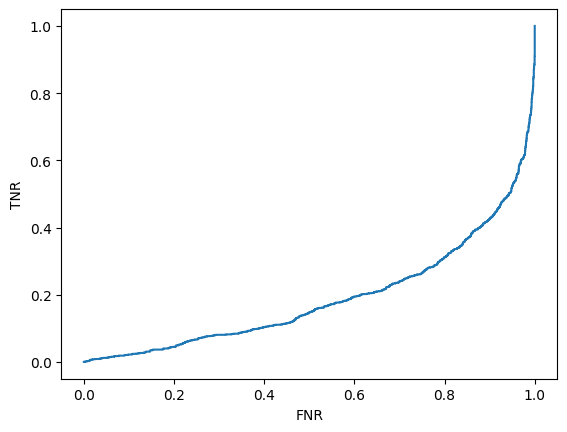

In [21]:
# Performance
test_acc = evaluation(retrained_model, test_dataloader)
mia = lira(retrained_model.cuda())
print(f'Test Acc: {test_acc}')
plt.plot(mia[0], mia[1])
plt.xlabel('FNR')
plt.ylabel('TNR')

#### <b>Machine Unlearning Experiments</b>

* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.

<b>Original Model Preformance</b>

[Test]
[Batch: 1] running test loss: 0.02343052625656128, running test accuracy: 0.53125, running top-2 accuracy: 0.796875
test loss: 0.02272895108266958, accuracy: 0.48278102664067574, top-2 accuracy: 0.7543859649122807
elapsed time: 1.4224789142608643


100%|██████████| 85/85 [01:55<00:00,  1.36s/it]


Test Acc: {'Loss': 0.02272895108266958, 'Acc': 0.48278102664067574, 'Top-2 Acc': 0.7543859649122807}


Text(0, 0.5, 'TNR')

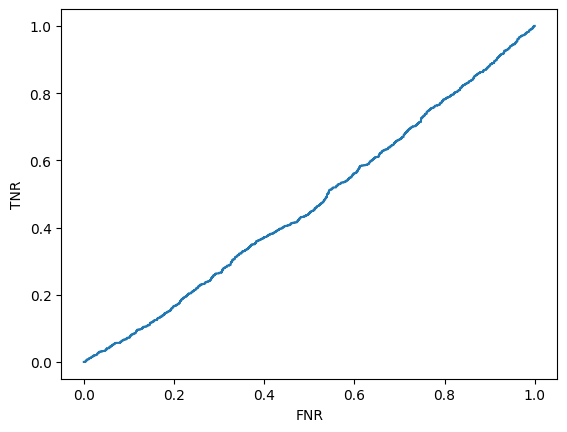

In [23]:
original_model = load_model('./checkpoints/origin/resnet18.pth')

# Performance
test_acc = evaluation(original_model, test_dataloader)
mia = lira(original_model.cuda())
print(f'Test Acc: {test_acc}')
plt.plot(mia[0], mia[1])
plt.xlabel('FNR')
plt.ylabel('TNR')

#### <b>UnGAN</b>
* Proposed unlearning method via GAN

In [41]:
hidden_size=64

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.class_embeddings = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(2*num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, logits, label):
        label_emb = self.class_embeddings(label)
        z = torch.hstack([logits, label_emb])
        return self.model(z).flatten()

class Trainer:
    def __init__(self, model):
        
        self.discriminator = Discriminator(8)
        self.model = model
        self.alpha = 0.1

        self.model.cuda()
        self.discriminator.cuda()
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, weight_decay=1e-5)
        self.d_criterion = nn.BCEWithLogitsLoss()

        self.g_optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        self.g_criterion = nn.CrossEntropyLoss(reduction='mean')
        

    def generator_step(self, forget_logits, forget_labels, retain_logits, retain_labels):
        
        ones = torch.ones(forget_logits.size(0)).cuda()
        forget_preds = self.discriminator(forget_logits, forget_labels)
        d_loss = self.d_criterion(forget_preds, ones)
        
        g_loss = self.g_criterion(retain_logits, retain_labels)

        loss = (1 - self.alpha) * d_loss + self.alpha * g_loss

        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()

        return loss.item()
        
    def discriminator_step(self, forget_logits, unseen_logits, forget_labels, unseen_labels):
        
        ones = torch.ones(unseen_logits.size(0)).cuda()
        zeros = torch.zeros(forget_logits.size(0)).cuda()
    
        forget_preds = self.discriminator(forget_logits, forget_labels)
        unseen_preds = self.discriminator(unseen_logits, unseen_labels)
    
        loss = self.d_criterion(forget_preds, zeros) + self.d_criterion(unseen_preds, ones)
        self.d_optimizer.zero_grad()
        loss.backward(retain_graph=False)
        self.d_optimizer.step()

        return loss.item()
        
        
def gan_unlearning(model, retain, forget, unseen):
    
    origin_model = deepcopy(model)
    origin_model.eval()
    origin_model.cuda()

    trainer = Trainer(model)
    epochs = 1
    step = 0
    n_range = 2
    average_loss = None

    batch = next(iter(unseen))
    unseen_features, unseen_labels = batch[0].cuda(), batch[1].cuda()
    with torch.no_grad():
        unseen_logits = origin_model(unseen_features)
    
    for epoch in range(epochs):
        
        for (forget_batch, retain_batch) in tqdm(zip(forget, retain), desc=f'epoch {epoch}/{epochs}', leave=False):
            
            step+= 1

            # discriminator step
            trainer.model.eval()
            for i in range(n_range):

                batch = next(iter(unseen))
                unseen_features, unseen_labels = batch[0].cuda(), batch[1].cuda()
                with torch.no_grad():
                    unseen_logits = origin_model(unseen_features)

                batch = next(iter(forget))
                forget_features, forget_labels = batch[0].cuda(), batch[1].cuda()
                with torch.no_grad():
                    forget_logits = trainer.model(forget_features)

                d_loss = trainer.discriminator_step(forget_logits, unseen_logits, forget_labels, unseen_labels)
                average_loss = d_loss if average_loss is None else 0.9 * average_loss + 0.1 * d_loss
                
                n_range = max(n_range//2, 1) if average_loss < 1.0 else 2
                    
                        
            # generator step
            trainer.model.train()
            retain_features, retain_labels = retain_batch[0].cuda(), retain_batch[1].cuda()
            retain_logits = trainer.model(retain_features)
            
            trainer.model.eval()
            forget_features, forget_labels = forget_batch[0].cuda(), forget_batch[1].cuda()
            forget_logits = trainer.model(forget_features)
            
            g_loss = trainer.generator_step(forget_logits, forget_labels, retain_logits, retain_labels)

    trainer.model.eval()

In [56]:
unlearned_model = load_model('./checkpoints/origin/resnet18.pth')

gan_unlearning(unlearned_model, retain_dataloader_test, forget_dataloader_test, unseen_dataloader_test)

epoch 0/1: 5it [00:16,  3.42s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7febdbe85a60>
Traceback (most recent call last):
  File "/home/user/conda/envs/zhavoronkin_env_ungan/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/user/conda/envs/zhavoronkin_env_ungan/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/user/conda/envs/zhavoronkin_env_ungan/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/user/conda/envs/zhavoronkin_env_ungan/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/user/conda/envs/zhavoronkin_env_ungan/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/user/co

[Test]
[Batch: 1] running test loss: 0.049892812967300415, running test accuracy: 0.296875, running top-2 accuracy: 0.609375
test loss: 0.05068005432627122, accuracy: 0.3326835607537362, top-2 accuracy: 0.6075373619233269
elapsed time: 2.365858316421509


100%|██████████| 85/85 [01:56<00:00,  1.36s/it]


Test Acc: {'Loss': 0.05068005432627122, 'Acc': 0.3326835607537362, 'Top-2 Acc': 0.6075373619233269}


Text(0, 0.5, 'TNR')

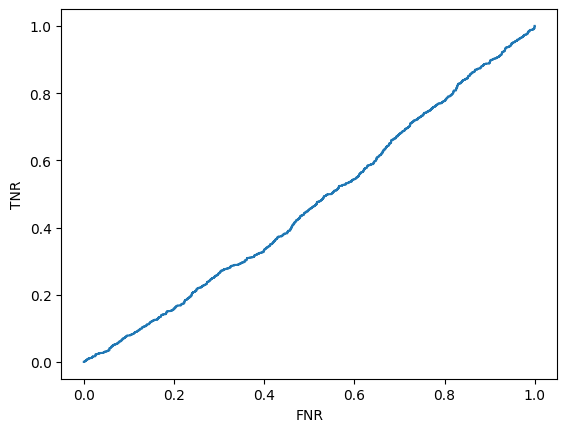

In [53]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
mia = lira(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
plt.plot(mia[0], mia[1])
plt.xlabel('FNR')
plt.ylabel('TNR')

#### <b>Fine-Tuning</b>
* A method where the original model undergoes further training solely on the retain dataset.
* This approach aims to reinforce the model's knowledge of the retain dataset, potentially leading to the forgetting of the previously learned forget dataset.

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(unlearned_model, test_dataloader)
test_acc

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearned_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

#### <b>CF-k (Class-wise Forgetting)</b>
* A strategy that fine-tunes specific layers to make the model forget target data while retaining class structures.

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
cf_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
# Print a weight set of a front layer in the network to check the freezing.
print(unlearned_model.layer1[0].conv1.weight[0][0])

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, unlearned_model.parameters()), lr=0.001)

# Freeze all the parameters.
for param in unlearned_model.parameters():
    param.requires_grad = False

# Only unfreeze the last three layers for the fine-tuning.
for param in unlearned_model.layer3.parameters():
    param.requires_grad = True
for param in unlearned_model.layer4.parameters():
    param.requires_grad = True
for param in unlearned_model.avgpool.parameters():
    param.requires_grad = True
for param in unlearned_model.fc.parameters():
    param.requires_grad = True

num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearned_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

In [ ]:
# Print a weight set of a front layer in the network to check the freezing.
print(unlearned_model.layer1[0].conv1.weight[0][0])

#### <b>Negative Gradient Ascent</b>
* A strategy that induces the model to 'forget' particular data by deliberately maximizing the error on the forget dataset.

<b>Normal NegGrad</b>

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

dataloader_iterator = iter(forget_dataloader_train)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != x_retain.size(0):
            continue

        outputs_forget = unlearned_model(x_forget.cuda())
        loss_ascent_forget = -criterion(outputs_forget, y_forget.cuda())

        optimizer.zero_grad()
        loss_ascent_forget.backward()
        optimizer.step()

        running_loss += loss_ascent_forget.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss_ascent_forget.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

<b>Advanced NegGrad with Classification Loss</b>

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

dataloader_iterator = iter(forget_dataloader_train)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != x_retain.size(0):
            continue

        outputs_retain = unlearned_model(x_retain.cuda())
        outputs_forget = unlearned_model(x_forget.cuda())

        loss_ascent_forget = -criterion(outputs_forget, y_forget.cuda())
        loss_retain = criterion(outputs_retain, y_retain.cuda())

        # Overall loss
        joint_loss = loss_ascent_forget + loss_retain

        print("joint loss :", joint_loss.item())
        optimizer.zero_grad()
        joint_loss.backward()
        optimizer.step()

        running_loss += joint_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {joint_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

#### <b>UNSIR</b>
* <b>Impair phase (Stage 1)</b>: Update noise to increase the distance between the model and the forget dataset. Then, the updated noise is then integrated into the training dataset to enhance the model's ability to forget the specific dataset.
* <b>Repair phase (Stage 2)</b>: Repair the impaired model using the retain dataset.

<b> Stage1: Impair</b>

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
unlearned_model = models.resnet18(pretrained=False)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)
unlearned_model.load_state_dict(torch.load(original_save_path))
unlearned_model = unlearned_model.cuda()
criterion = nn.CrossEntropyLoss()

test_acc = evaluation(unlearned_model, test_dataloader)
test_acc

In [ ]:
class Noise(nn.Module):
    def __init__(self, batch_size, *dim):
        super().__init__()
        self.noise = nn.Parameter(torch.randn(batch_size, *dim), requires_grad=True)

    def forward(self):
        return self.noise

def float_to_uint8(img_float):
    """Convert a floating point image in the range [0,1] to uint8 image in the range [0,255]."""
    img_uint8 = (img_float * 255).astype(np.uint8)
    return img_uint8

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

print_interval = 1
train_epoch_losses = []

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, ((x_retain, y_retain), (x_forget, y_forget)) in enumerate(zip(retain_dataloader_train, forget_dataloader_train)):
        y_retain = y_retain.cuda()
        batch_size_forget = y_forget.size(0)

        if x_retain.size(0) != 64 or x_forget.size(0) != 64:
            continue

        # Initialize the noise.
        noise_dim = x_retain.size(1), x_retain.size(2), x_retain.size(3)
        noise = Noise(batch_size_forget, *noise_dim).cuda()
        noise_optimizer = torch.optim.Adam(noise.parameters(), lr=0.01)
        noise_tensor = noise()[:batch_size_forget]

        # Update the noise for increasing the loss value.
        for _ in range(5):
            outputs = unlearned_model(noise_tensor)
            with torch.no_grad():
                target_logits = unlearned_model(x_forget.cuda())
            # Maximize the similarity between noise data and forget features.
            loss_noise = -F.mse_loss(outputs, target_logits)

            # Backpropagate to update the noise.
            noise_optimizer.zero_grad()
            loss_noise.backward(retain_graph=True)
            noise_optimizer.step()

        # Train the model with noise and retain image
        noise_tensor = torch.clamp(noise_tensor, 0, 1).detach().cuda()
        outputs = unlearned_model(noise_tensor.cuda())
        loss_1 = criterion(outputs, y_retain)

        outputs = unlearned_model(x_retain.cuda())
        loss_2 = criterion(outputs, y_retain)

        joint_loss = loss_1 + loss_2

        optimizer.zero_grad()
        joint_loss.backward()
        optimizer.step()
        running_loss += joint_loss.item() * x_retain.size(0)

        original_image = x_retain[0].cpu().numpy().transpose(1, 2, 0)
        image1 = TF.to_pil_image(float_to_uint8(original_image))
        image2 = TF.to_pil_image(noise.noise[0].cpu())

        # Display original image.
        original_image = x_retain[0].cpu().numpy().transpose(1, 2, 0)
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)  # 2 rows, 2 columns, position 1
        plt.imshow(image1)
        plt.title("Original Image")
        plt.axis('off')

        # Display first noise image.
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
        plt.title("Noise Image")
        plt.axis('off')

        # Show all the subplots.
        plt.tight_layout()
        plt.show()

        if batch_idx % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {joint_loss.item():.4f}")

    average_train_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    train_epoch_losses.append(average_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {average_train_loss:.4f}")

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

<b>Stage 2: Repair</b>

In [ ]:
set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0

    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):
        y_retain = y_retain.cuda()

        # Classification Loss
        outputs_retain = unlearned_model(x_retain.cuda())
        classification_loss = criterion(outputs_retain, y_retain)

        optimizer.zero_grad()
        classification_loss.backward()
        optimizer.step()

        running_loss += classification_loss.item() * x_retain.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {classification_loss.item():.4f}")

    average_epoch_loss = running_loss / (len(retain_dataloader_train) * x_retain.size(0))
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {running_loss:.4f}")

In [ ]:
# Performance
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)
mia = cal_mia(unlearned_model.cuda())
print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

#### <b>Scrub</b>

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 8)
original_model.load_state_dict(torch.load(original_save_path))
original_model = original_model.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
# print(f'last_checkpoint_epoch_{num_original_epochs}.pth')
# original_save_path = f'last_checkpoint_epoch_{num_original_epochs}.pth' # If you trian the original model from scratch.
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'
scrub_model = models.resnet18(pretrained=False)
num_features = scrub_model.fc.in_features
scrub_model.fc = nn.Linear(num_features, 8)
scrub_model.load_state_dict(torch.load(original_save_path))
scrub_model = scrub_model.cuda()
criterion = nn.CrossEntropyLoss()

In [ ]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [ ]:
class SCRUBTraining:
    def __init__(self, teacher, student, retain_dataloader, forget_dataloader):
        self.teacher = teacher
        self.student = student
        self.retain_dataloader = retain_dataloader
        self.forget_dataloader = forget_dataloader

        self.criterion_cls = nn.CrossEntropyLoss()
        self.criterion_div = DistillKL(4.0)
        self.criterion_kd = DistillKL(4.0)

        self.optimizer = optim.SGD(student.parameters(), lr=0.001)

    def train_epoch(self):
        self.student.train()
        self.teacher.eval()

        # Function to compute accuracy.
        def compute_accuracy(outputs, labels):
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            return 100 * correct / total

        total_loss_retain, total_accuracy_retain = 0, 0
        total_loss_forget, total_accuracy_forget = 0, 0

        # Training with retain data.
        for inputs_retain, labels_retain in self.retain_dataloader:
            inputs_retain, labels_retain = inputs_retain.cuda(), labels_retain.cuda()

            # Forward pass: Student
            outputs_retain_student = self.student(inputs_retain)

            # Forward pass: Teacher
            with torch.no_grad():
                outputs_retain_teacher = self.teacher(inputs_retain)

            # Loss computation
            loss_cls = self.criterion_cls(outputs_retain_student, labels_retain)
            loss_div_retain = self.criterion_div(outputs_retain_student, outputs_retain_teacher)

            loss = loss_cls + loss_div_retain

            # Update total loss and accuracy for retain data.
            total_loss_retain += loss.item()
            total_accuracy_retain += compute_accuracy(outputs_retain_student, labels_retain)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Training with forget data.
        for inputs_forget, labels_forget in self.forget_dataloader:
            inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

            # Forward pass: Student
            outputs_forget_student = self.student(inputs_forget)

            # Forward pass: Teacher
            with torch.no_grad():
                outputs_forget_teacher = self.teacher(inputs_forget)

            # We want to maximize the divergence for the forget data.
            loss_div_forget = -self.criterion_div(outputs_forget_student, outputs_forget_teacher)

            # Update total loss and accuracy for forget data.
            total_loss_forget += loss_div_forget.item()
            total_accuracy_forget += compute_accuracy(outputs_forget_student, labels_forget)

            # Backward pass
            self.optimizer.zero_grad()
            loss_div_forget.backward()
            self.optimizer.step()

        # Print average loss and accuracy for the entire epoch
        avg_loss_retain = total_loss_retain / len(self.retain_dataloader)
        avg_accuracy_retain = total_accuracy_retain / len(self.retain_dataloader)

        avg_loss_forget = total_loss_forget / len(self.forget_dataloader)
        avg_accuracy_forget = total_accuracy_forget / len(self.forget_dataloader)

        print(f'Epoch Retain: Avg Loss: {avg_loss_retain:.4f}, Avg Accuracy: {avg_accuracy_retain:.2f}%')
        print(f'Epoch Forget: Avg Loss: {avg_loss_forget:.4f}, Avg Accuracy: {avg_accuracy_forget:.2f}%')

In [ ]:
teacher = original_model
student = scrub_model

# Initialize and train
scrub_trainer = SCRUBTraining(teacher, student, retain_dataloader_train, forget_dataloader_train)

num_epochs = 2
for epoch in range(num_epochs):
    scrub_trainer.train_epoch()
    print(f"Epoch {epoch+1} completed.")

In [ ]:
# Performance
test_acc = evaluation(scrub_model, test_dataloader)
unseen_acc = evaluation(scrub_model, unseen_dataloader)
mia = cal_mia(scrub_model.cuda())
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')